In [18]:
import FinanceDataReader as fdr
import numpy as np

etfkr = fdr.StockListing("ETF/KR")
krx = fdr.StockListing("KRX")

def search_code(name):
    code = krx[krx['Name'] == name]['Code']
    # 결과가 있으면 해당 종목 코드를 반환하고, 없으면 None 반환
    if not code.empty:
        return code.values[0]

    code = etfkr[etfkr['Name'].str.strip() == name]['Symbol']
    # display(code)    
    if not code.empty:
        return code.values[0]
        
    return np.nan

# 종목명 = 'RISE 미국30년국채엔화노출(합성 H)'
# 코드 = search_code(종목명)
# display(코드)
# 'RISE 미국채30년엔화노출(합성 H)'
# test = etfkr[etfkr['Name'].str.contains('RISE')]
# display(test['Name'].values)
# test['Name'].values == 'RISE 미국30년국채엔화노출(합성 H)'


In [32]:
import pandas as pd
import os

# CSV 파일을 줄 단위로 읽기

def read_csv(file_path):
    file_name = os.path.basename(file_path)
    file_prefix = file_name.split('-')[0] 

    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    # 홀수 줄과 짝수 줄을 결합하여 하나의 줄로 만듬
    merged_lines = []
    for i in range(0, len(lines) - 1, 2):
        merged_line = lines[i].strip() + ',' + lines[i + 1].strip()  # 쉼표를 이용해 두 줄 결합
        merged_lines.append(merged_line)

    # 결합된 데이터를 DataFrame으로 바로 변환
    from io import StringIO

    # 결합된 라인들을 하나의 문자열로 변환
    merged_data = "\n".join(merged_lines)

    # pandas에서 이를 읽어들이기 위해 StringIO 객체로 변환
    df = pd.read_csv(StringIO(merged_data))
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    
    if '거래일자' in df.columns:
        df = df.rename(columns={'거래일자': '거래일'})

    if '거래상세유형' in df.columns:
        df = df.rename(columns={'거래상세유형': '거래종류'})
        
    if '종목명' in df.columns:
        df = df.rename(columns={'종목명': '상품명'})
        
    df['계좌'] = file_prefix[:8] + '-' + file_prefix[8:]
    df['코드'] = 0
    df['거래금'] = df['거래금액']
    df['정산금'] = df['정산금액']
    df['수량'] = df['거래수량']
    df['종류'] = df['거래종류']
        
    df['종류'] = df['종류'].str.replace('[', '', regex=False).str.replace(']', '', regex=False)
    df['종류'] = df['종류'].str.replace('Smart+', '', regex=False)
       
    df['거래금'] = df['거래금'].astype(str).str.replace(',', '')
    df['거래금'] = pd.to_numeric(df['거래금'], errors='coerce')
    df['정산금'] = df['정산금'].astype(str).str.replace(',', '')
    df['정산금'] = pd.to_numeric(df['정산금'], errors='coerce')
    df['수량'] = df['수량'].astype(str).str.replace(',', '')
    df['수량'] = pd.to_numeric(df['수량'], errors='coerce')
    
    df.loc[df['수량'] == 0, '수량'] = df['거래금']
    df['단가'] = df['거래금'] / df['수량']
    df['단가'] = pd.to_numeric(df['단가'], errors='coerce')
    
    # '상품명' 컬럼에서 NaN 값을 '현금성자산'으로 변경
    df.loc[df['상품명'].isna(), '상품명'] = '현금성자산'
    df = df[['거래일', '종류', '거래금', '수수료', '세금', '정산금', '단가', '수량', '계좌', '상품명', '코드']]
    
    df = df[~df['종류'].str.contains('전환')]
    
    df['거래일'] = pd.to_datetime(df['거래일'], format='%Y.%m.%d')
    df.set_index('거래일', inplace=True)
    df = df.sort_index()
    
    return df

# 결과 출력
df1 = read_csv('6401254829-20240908.csv')
df2 = read_csv('6401254822-20240907.csv')
df3 = read_csv('6398149401-20240907.csv')
df4 = read_csv('6426731622-20240908.csv')
df5 = read_csv('6404327801-20240908.csv')

# display(df1)
# display(df2)
# display(df3)
# display(df4)
# display(df5)

df = pd.concat([df1, df2, df3, df4, df5])
df.sort_index(inplace=True)

# display(df)


In [34]:

# display(df)

현금성자산 = df[~df['종류'].str.contains('거래소')]

입금 = df[df['종류'].str.contains('이체입금|부담금')]
출금 = df[df['종류'].str.contains('출금')]
분배금 = df[df['종류'].str.contains('분배금')]
이자 = df[df['종류'].str.contains('이자|이용료')]
주식 = df[df['종류'].str.contains('거래소')]

display(입금)
display(출금)
display(분배금)
display(이자)

총입금 = 입금['정산금'].sum() 
총출금 = 출금['정산금'].sum()
총분배금 = 분배금['정산금'].sum() 
총이자 = 이자['정산금'].sum()
print(총입금)
print(총출금)
print(총분배금)
print(총이자)
총금액 = 총입금 - 총출금
총금액

,종류,거래금,수수료,세금,정산금,단가,수량,계좌,상품명,코드
거래일,,,,,,,,,,
2023-12-22,기본부담금,1000000,0,0,1000000,1.0,1000000,64012548-29,현금성자산,0
2023-12-22,당사이체입금,5000000,0,0,5000000,1.0,5000000,64012548-22,현금성자산,0
2023-12-27,당사이체입금,1000000,0,0,1000000,1.0,1000000,64012548-22,현금성자산,0
2023-12-27,타사이체입금,2000000,0,0,2000000,1.0,2000000,63981494-01,현금성자산,0
2023-12-27,타사이체입금,1000000,0,0,1000000,1.0,1000000,63981494-01,현금성자산,0
2023-12-27,기본부담금,2000000,0,0,2000000,1.0,2000000,64012548-29,현금성자산,0
2024-02-14,타사이체입금,1000000,0,0,1000000,1.0,1000000,64012548-22,현금성자산,0
2024-02-20,타사이체입금,1000000,0,0,1000000,1.0,1000000,64012548-22,현금성자산,0
2024-02-28,타사이체입금,1000000,0,0,1000000,1.0,1000000,64012548-22,현금성자산,0


,종류,거래금,수수료,세금,정산금,단가,수량,계좌,상품명,코드
거래일,,,,,,,,,,
2023-12-27,당사이체출금,2000000,0,0,2000000,1.0,2000000,63981494-01,현금성자산,0
2023-12-27,당사이체출금,1000000,0,0,1000000,1.0,1000000,63981494-01,현금성자산,0
2024-05-08,타사이체출금,1003916,0,0,1003916,1.0,1003916,63981494-01,현금성자산,0
2024-05-09,타사이체출금,2278500,0,0,2278500,1.0,2278500,64043278-01,현금성자산,0
2024-06-10,타사이체출금,1000000,0,0,1000000,1.0,1000000,63981494-01,현금성자산,0
2024-07-09,타사이체출금,1487224,0,0,1487224,1.0,1487224,63981494-01,현금성자산,0
2024-07-10,타사이체출금,1509437,0,0,1509437,1.0,1509437,63981494-01,현금성자산,0
2024-08-12,타사이체출금,715399,0,0,715399,1.0,715399,63981494-01,현금성자산,0


,종류,거래금,수수료,세금,정산금,단가,수량,계좌,상품명,코드
거래일,,,,,,,,,,
2024-01-03,ETF분배금입금,3500,0,0,3500,1.0,3500,64012548-29,KOSEF 국고채10년,0
2024-02-02,ETF분배금입금,15,0,0,15,1.0,15,64012548-22,KB KBSTAR 미국반도체NYSE증권상장지수투자신탁(주식)(H),0
2024-02-02,ETF분배금입금,1820,0,0,1820,1.0,1820,64012548-29,ACE 미국S&P500,0
2024-02-02,ETF분배금입금,3465,0,0,3465,1.0,3465,64012548-29,KODEX 차이나CSI300,0
2024-02-02,ETF분배금입금,1300,0,0,1300,1.0,1300,64012548-22,한국투자 ACE 미국S&P500증권상장지수투자신탁(주식),0
...,...,...,...,...,...,...,...,...,...,...
2024-09-03,ETF분배금입금,14560,0,0,14560,1.0,14560,64012548-29,KODEX iShares미국하이일드액티브,0
2024-09-03,ETF분배금입금,65025,0,0,65025,1.0,65025,64267316-22,미래에셋 TIGER 미국S&P500+10%프리미엄초단기옵션증권상장지수_,0
2024-09-03,ETF분배금입금,840,0,0,840,1.0,840,64267316-22,한국투자 ACE 미국30년국채엔화노출액티브증권상장지수투자신탁[,0


,종류,거래금,수수료,세금,정산금,단가,수량,계좌,상품명,코드
거래일,,,,,,,,,,
2023-12-26,정기대기이자입금,382,0,0,382,1.0,382,64012548-29,현금성자산,0
2023-12-27,정기대기이자입금,96,0,0,96,1.0,96,64012548-29,현금성자산,0
2023-12-28,정기대기이자입금,203,0,0,203,1.0,203,64012548-29,현금성자산,0
2023-12-29,정기대기이자입금,203,0,0,203,1.0,203,64012548-29,현금성자산,0
2024-01-02,정기대기이자입금,810,0,0,810,1.0,810,64012548-29,현금성자산,0
...,...,...,...,...,...,...,...,...,...,...
2024-09-02,예탁금이용료,1864,0,0,1864,1.0,1864,64267316-22,현금성자산,0
2024-09-02,예탁금이용료,571,0,0,571,1.0,571,64012548-22,현금성자산,0
2024-09-04,정기대기이자입금,13,0,0,13,1.0,13,64012548-29,현금성자산,0


110884981
10994476
1223517
41857


99890505

In [95]:
일별입금 = 입금.groupby('거래일').agg({'정산금': 'sum'})
일별출금 = 출금.groupby('거래일').agg({'정산금': 'sum'})
일별분배금 = 분배금.groupby('거래일').agg({'정산금': 'sum'})
일별이자 = 이자.groupby('거래일').agg({'정산금': 'sum'})

일별입금 = 일별입금.resample('D').sum().fillna(0)
일별출금 = 일별출금.resample('D').sum().fillna(0)
일별분배금 = 일별분배금.resample('D').sum().fillna(0)
일별이자 = 일별이자.resample('D').sum().fillna(0)

일별입금.columns = ['입금']
일별출금.columns = ['출금']
일별분배금.columns = ['분배금']
일별이자.columns = ['이자']
입출금 = pd.concat([일별입금, 일별출금, 일별분배금, 일별이자], axis=1).fillna(0)
입출금['잔고1'] = 입출금['입금'] - 입출금['출금']
입출금['잔고1'] = 입출금['잔고1'].cumsum()
입출금['잔고2'] = 입출금['입금'] - 입출금['출금'] + 입출금['분배금'] + 입출금['이자']
입출금['잔고2'] = 입출금['잔고2'].cumsum()
# 입출금['잔고2'

# 일별입출금 = 입금['정산금'] - 출금['정산금']
# 입출금 = pd.merge(일별입금, 일별출금, on='거래일', how='outer').fillna(0)
# 입출금['test'] = 입출금['잔고_x'] - 입출금['잔고_y']
# 일별입금.set_columns(['입금'])
# # display(일별입금)
# 일별입금['잔고'] = 일별입금['입금'].cumsum()

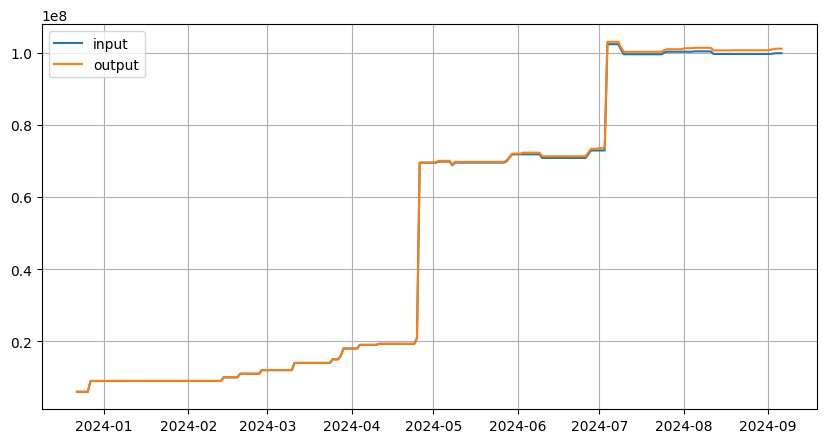

In [96]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(입출금['잔고1'], label='input')
plt.plot(입출금['잔고2'], label='output')
plt.grid(True)
plt.legend()
